In [2]:
import os
import sys 
import glob
import dask
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from leakage.velocity_leakage import S1DopplerLeakage, add_dca_to_leakage_class
from leakage.misc import round_to_hour, angular_difference, calculate_distance

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
data_dir_dca = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"

scenarios = [
    'Aghulas_20200309',
    'Aghulas_20200321',
    'Aghulas_20200402',
    'Aghulas_20200414',
    'Aghulas_20200426'
    ]

scenarios = [
    # 'Aghulas_20200203',
    'Aghulas_20200215',
    'Aghulas_20200227',
    'Aghulas_20200310',
    'Aghulas_20200322',
    'Aghulas_20200403',
    'Aghulas_20200415',
    'Aghulas_20200427',
]

In [72]:
# noises = []
# signals = []
results = []
for i, scenario in enumerate(scenarios):
    files = glob.glob(f"{data_dir+scenario}/*.SAFE")

    test = S1DopplerLeakage(
        filename=files,
        f0 = 5_400_000_000,
        z0 = 823_000,
        era5_directory='../../data/leakage/era5_winds/',
        resolution_product=50_000,
        az_footprint_cutoff=80_000,
        vx_sat=6_800,
        PRF=4,
        grid_spacing=150,
        antenna_length=2.87,
        antenna_height=0.32,
        beam_pattern= 'phased_array', #'phased_array', sinc
        antenna_elements=4,
        antenna_weighting=0.75,
        swath_start_incidence_angle_scat=35,
        boresight_elevation_angle_scat=40,
        random_state = 42 + i,
        fill_nan_limit = None,

        # era5_smoothing_window=30,
        # denoise = True,
        # _pulsepair_noise = True
        # _speckle_noise= True
        )
    test.apply()

    data_dir_dca = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
    files_dca = glob.glob(f"{data_dir_dca+scenario}/*.nc")
    
    add_dca_to_leakage_class(test, files_dca=files_dca)
    results.append(test)

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200309/0D9A_2A1B_4B1D_63F6_9B2F_FAFB_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200309h1800_lat-35_7_lon18_3.nc


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:306: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200321/0407_0528_2434_7A73_BC55_E4A7_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200321h1800_lat-35_7_lon18_3.nc


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:306: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200402/6711_9DCB_A4DE_E160_E5C6_FD45_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200402h1800_lat-35_7_lon18_3.nc


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:306: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200414/1D90_53E2_5873_AD57_BF28_D8EC_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200414h1800_lat-35_7_lon18_3.nc


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:306: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200426/1BD9_4FDB_70EB_7666_DC9A_E3C8_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200426h1800_lat-35_7_lon18_3.nc


In [73]:
func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)
func_rmse_xr = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)), rounding)

In [74]:
samples = results #results[:3] + [results[-1]] # results

residuals = [result.data.V_leakage_pulse_rg_subscene - result.data.V_leakage_pulse_rg_subscene_inverted for result in samples]
backscatters = [result.data.nrcs_scat for result in samples]
signals = [result.data.V_dca_pulse_rg_subscene for result in samples]
currents =  [result.data.V_dca_pulse_rg_subscene - result.data.V_wb_pulse_rg_subscene for result in samples]
noise = [result.data.V_sigma_subscene - result.data.V_leakage_pulse_rg_subscene_inverted for result in samples]

In [75]:
ds_residual = xr.concat(residuals, dim = 'time')#.sel(slow_time = slice(0, 350E3))#.T.plot(robust = True, cmap = cmc.vik)
ds_currents = xr.concat(currents, dim = 'time')#.T.plot(robust = True, cmap = cmc.vik)
ds_nrcs = xr.concat(backscatters, dim = 'time')#.sel(slow_time = slice(0, 350E3))
ds_noise = xr.concat(noise, dim = 'time')#.sel(slow_time = slice(0, 350E3))

clip_1 = ds_currents/ds_currents
clip_2 = ds_residual/ds_residual

ds_residual = ds_residual * clip_1
ds_currents = ds_currents * clip_2
ds_noise = ds_noise * clip_2 * clip_1

ds_residual_mean = ds_residual.mean(dim = 'time')
ds_residual_std = ds_residual.std(dim = 'time')
ds_noise_mean = ds_noise.mean(dim = 'time')
ds_currents_mean = ds_currents.mean(dim = 'time')

print('leakage:', func_rmse(ds_residual_mean), ds_residual.groupby('time',squeeze=False).map(func_rmse_xr).values, '\n')
print('noise:', func_rmse(ds_noise_mean), ds_noise.groupby('time',squeeze=False).map(func_rmse_xr).values, '\n')
print('signal:', func_rmse(ds_currents_mean), ds_currents.groupby('time',squeeze=False).map(func_rmse_xr).values, '\n')

leakage: 0.234 [0.499 0.454 0.449 0.769 0.41 ] 

noise: 1.062 [2.399 2.453 2.379 2.568 2.34 ] 

signal: 0.178 [0.366 0.485 0.698 0.492 0.609] 



In [76]:
(np.mean(ds_residual.groupby('time',squeeze=False).map(func_rmse_xr).values), np.mean(ds_noise.groupby('time',squeeze=False).map(func_rmse_xr).values), np.mean(ds_currents.groupby('time',squeeze=False).map(func_rmse_xr).values)) 

(0.5162, 2.4278, 0.53000003)

In [77]:
(np.mean(ds_residual.groupby('time',squeeze=False).map(func_rmse_xr).values), np.mean(ds_noise.groupby('time',squeeze=False).map(func_rmse_xr).values), np.mean(ds_currents.groupby('time',squeeze=False).map(func_rmse_xr).values))  / np.sqrt(len(samples)) 

array([0.23085165, 1.0857451 , 0.23702322], dtype=float32)

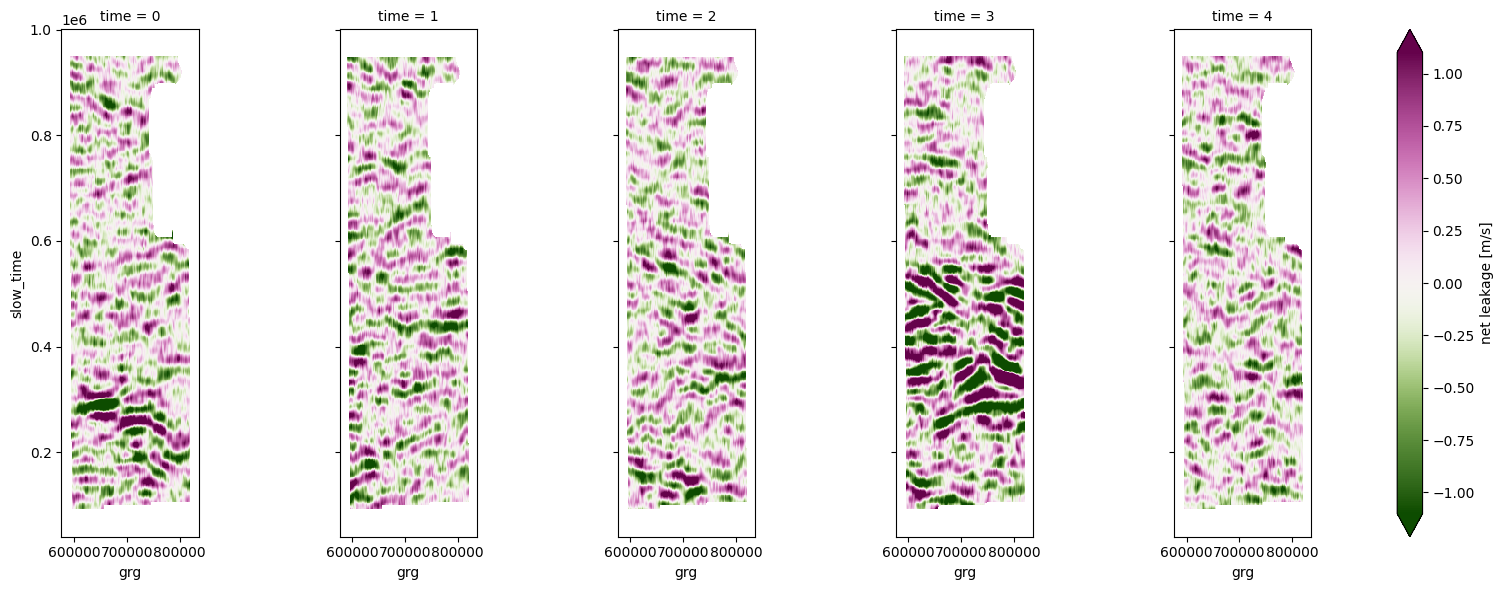

In [91]:
a = ds_residual.plot(x='grg', y = 'slow_time', col = 'time', robust = True, cmap = cmc.bam_r, figsize = (18,6), cbar_kwargs = {'label':'net leakage [m/s]'})
_ = [ax.axes.set_aspect('equal') for ax in a.axs.ravel()]

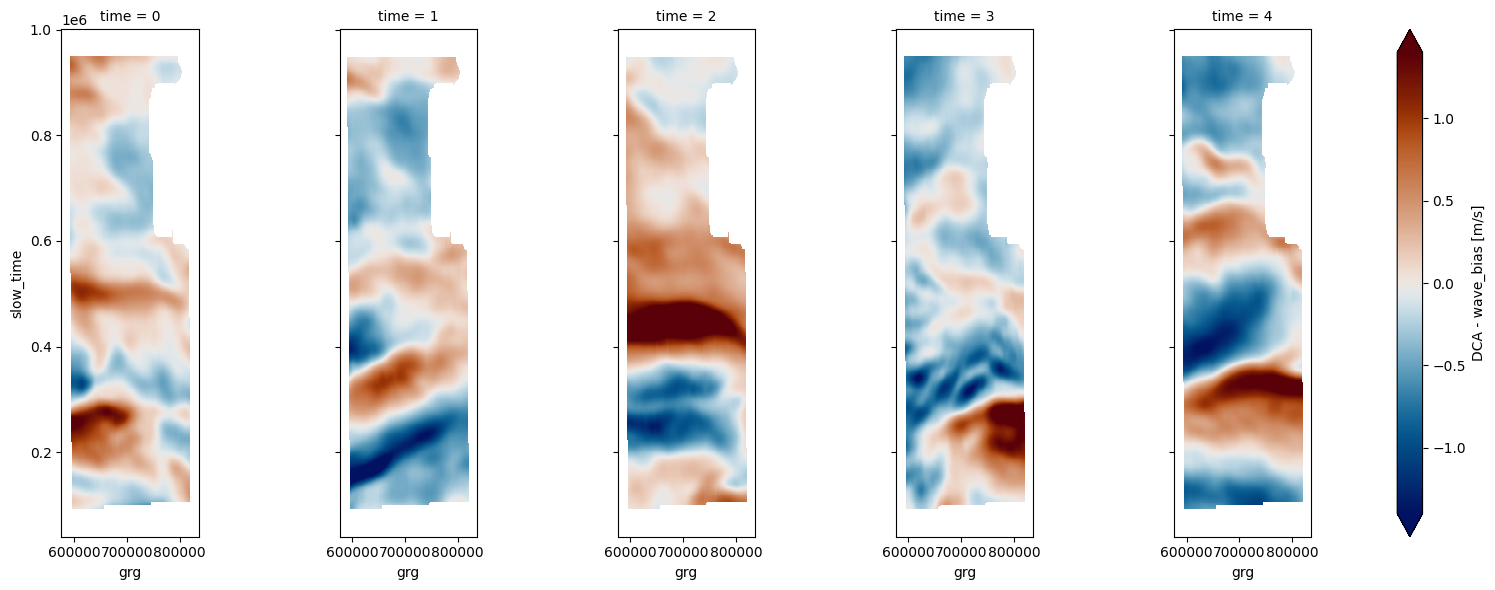

In [79]:
a = ds_currents.plot(x='grg', y = 'slow_time', col = 'time', robust = True, cmap = cmc.vik, figsize = (18,6), cbar_kwargs = {'label':'DCA - wave_bias [m/s]'})
_ = [ax.axes.set_aspect('equal') for ax in a.axs.ravel()]

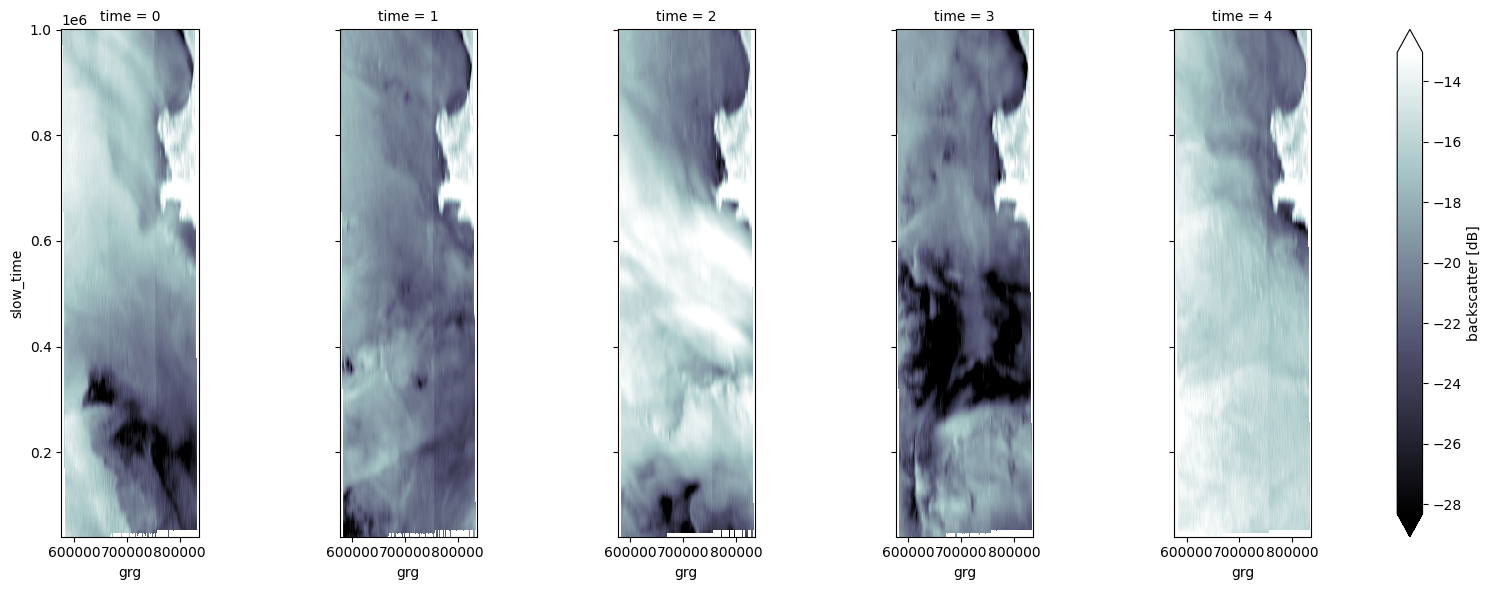

In [80]:
a = (10*np.log10(ds_nrcs)).plot(x='grg', y = 'slow_time', col = 'time', robust = True, cmap = 'bone', figsize = (18,6), cbar_kwargs = {'label':'backscatter [dB]'})
_ = [ax.axes.set_aspect('equal') for ax in a.axs.ravel()]

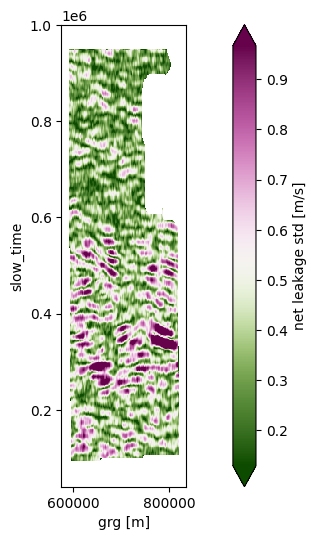

In [81]:
a = ds_residual_std.T.plot(robust = True, cmap = cmc.bam_r, figsize = (12,6), cbar_kwargs = {'label':'net leakage std [m/s]'})
a.axes.set_aspect('equal')

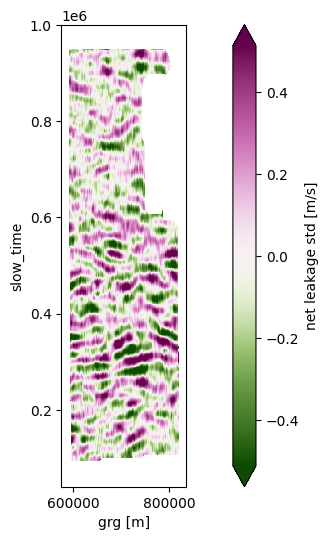

In [83]:
a = ds_residual_mean.T.plot(robust = True, cmap = cmc.bam_r, figsize = (12,6), cbar_kwargs = {'label':'net leakage std [m/s]'})
a.axes.set_aspect('equal')

In [84]:
def signal_2_noise_ratio(signal, noise):
    return signal**2 / noise**2

def to_decibel(x):
    return 10*np.log10(x)

def from_decibel(x):
    return 10**(x/10)

In [88]:
snr = to_decibel(signal_2_noise_ratio(signal=ds_currents, noise=ds_noise))

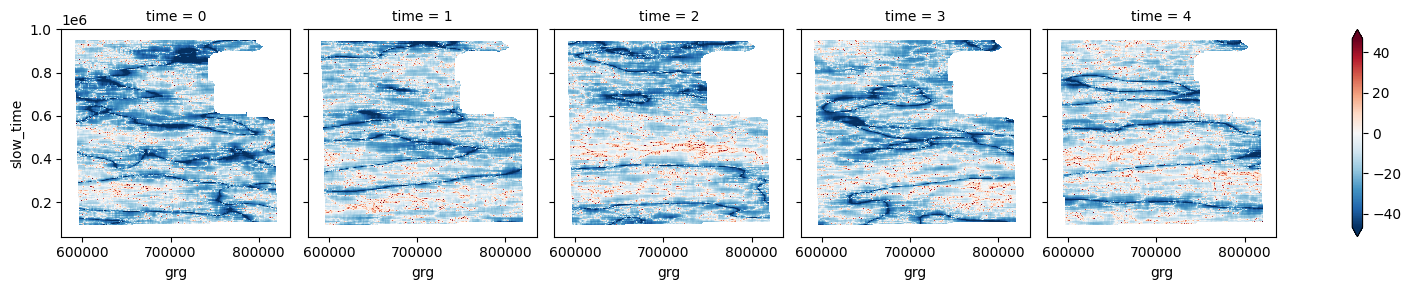

In [89]:
snr.plot(x = 'grg', y='slow_time', col = 'time', robust = True)

individual snr -18.776283 14.823558
individual snr -14.238651 13.580348
individual snr -13.263576 14.587034
individual snr -15.55174 14.301576
individual snr -11.248056 14.015501
average SNR -14.616035 14.487475
SNR of averaged -15.121261 13.46049


Text(0, 0.5, 'Relative occurence')

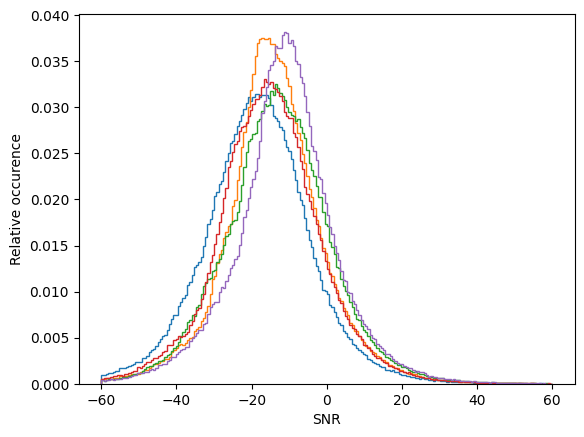

In [90]:
plt.figure()
for i in range(snr.sizes['time']):
    _ = snr.isel(time = i).plot.hist(bins = 200, range = (-60, 60), alpha = 1, density = True, histtype = 'step')
    print('individual snr', np.nanmean(snr.isel(time = i)), np.nanstd(snr.isel(time = i)))
# plt.title('Signal to noise distribution')
print('average SNR', np.nanmean(snr), np.nanstd(snr))

snr_of_mean = to_decibel(signal_2_noise_ratio(signal=ds_currents_mean, noise=ds_noise_mean))
print('SNR of averaged', np.nanmean(snr_of_mean), np.nanstd(snr_of_mean))
plt.xlabel('SNR')
plt.ylabel('Relative occurence')